In [1]:
import rasterio
import rasterio.transform
import rasterio.mask
import fiona
import shapely
import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
import pyproj

from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.basemap as pbm

import rasterio.features
import rasterio.windows
from rasterio.windows import Window

In [2]:
# warping crs
def warp_xy(x, y, old_crs, new_crs):
    """Warps a set of points from old_crs to new_crs."""
    if old_crs == new_crs:
        return x,y

    old_crs_proj = pyproj.Proj(old_crs)
    new_crs_proj = pyproj.Proj(new_crs)
    return pyproj.transform(old_crs_proj, new_crs_proj, x,y)

def warp_shapely(shp, old_crs, new_crs):
    """Uses proj to reproject shapes, NOT IN PLACE"""
    if old_crs['init'] == new_crs['init']:
        return shp

    old_crs_proj = pyproj.Proj(old_crs)
    new_crs_proj = pyproj.Proj(new_crs)
    return shapely.ops.transform(lambda x,y:pyproj.transform(old_crs_proj, new_crs_proj, x,y), shp)

def warp_shape(feature, old_crs, new_crs):
    """Uses proj to reproject shapes, IN PLACE"""
    if old_crs == new_crs:
        return
    if len(feature['geometry']['coordinates']) is 0:
        return

    # find the dimension -- can't trust the shape
    dim = -1
    ptr = feature['geometry']['coordinates']
    done = False
    while not done:
        if hasattr(ptr, '__len__'):        
            assert(len(ptr) is not 0)
            dim += 1
            ptr = ptr[0]
        else:
            done = True

    if dim == 0:
        # point
        x,y = warp_xy(np.array([feature['geometry']['coordinates'][0],]), np.array([feature['geometry']['coordinates'][1],]), old_crs, new_crs)
        feature['geometry']['coordinates'][0] = x[0]
        feature['geometry']['coordinates'][1] = x[1]
    elif dim == 1:
        # line-like or polygon with no holes
        coords = np.array(feature['geometry']['coordinates'],'d')
        assert(len(coords.shape) is 2 and coords.shape[1] in [2,3] )
        x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
        new_coords = [xy for xy in zip(x,y)]
        feature['geometry']['coordinates'] = new_coords
    elif dim == 2:
        # multi-line or polygon with holes
        for i in range(len(feature['geometry']['coordinates'])):
            coords = np.array(feature['geometry']['coordinates'][i],'d')
            assert(len(coords.shape) is 2 and coords.shape[1] in [2,3])
            x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
            new_coords = [xy for xy in zip(x,y)]
            feature['geometry']['coordinates'][i] = new_coords
    elif dim == 3:
        # multi-polygon
        for i in range(len(feature['geometry']['coordinates'])):
            for j in range(len(feature['geometry']['coordinates'][i])):
                coords = np.array(feature['geometry']['coordinates'][i][j],'d')
                assert(len(coords.shape) is 2 and coords.shape[1] in [2,3])
                x,y = warp_xy(coords[:,0], coords[:,1], old_crs, new_crs)
                new_coords = [xy for xy in zip(x,y)]
                feature['geometry']['coordinates'][i][j] = new_coords
            
                    
    


In [3]:
# import CBSA shapes
with fiona.open(r'..\Data (Used)\tl_2017_us_cbsa\tl_2017_us_cbsa.shp', 'r') as fid:
    cbsas = list(fid)
    cbsas_profile = fid.profile


# prints the profile of the cbsas
print(cbsas_profile)


print("we found {} shapes".format(len(cbsas)))

{'driver': 'ESRI Shapefile', 'schema': {'properties': OrderedDict([('CSAFP', 'str:3'), ('CBSAFP', 'str:5'), ('GEOID', 'str:5'), ('NAME', 'str:100'), ('NAMELSAD', 'str:100'), ('LSAD', 'str:2'), ('MEMI', 'str:1'), ('MTFCC', 'str:5'), ('ALAND', 'int:14'), ('AWATER', 'int:14'), ('INTPTLAT', 'str:11'), ('INTPTLON', 'str:12')]), 'geometry': 'Polygon'}, 'crs': {'init': 'epsg:4269'}, 'crs_wkt': 'GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]]'}
we found 945 shapes


C:\Users\moranedw000\.conda\envs\gis\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  after removing the cwd from sys.path.
C:\Users\moranedw000\.conda\envs\gis\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """
C:\Users\moranedw000\.conda\envs\gis\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


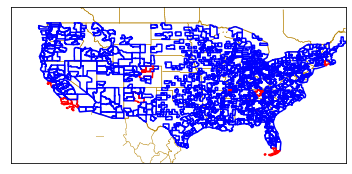

In [4]:
# plot the shapes
plt.figure()

bm = pbm.Basemap(llcrnrlon=-130, llcrnrlat=23, urcrnrlon=-68, urcrnrlat=52, resolution='h', epsg=cbsas_profile['crs']['init'][5:])
bm.drawcountries(linewidth=1, color='darkgoldenrod')
bm.drawstates(color='darkgoldenrod')

# -- convert to shapely
for shp in cbsas:
    shply = shapely.geometry.shape(shp['geometry'])
    if type(shply) is shapely.geometry.Polygon:
        xy = np.array(shply.exterior.xy)
        plt.plot(xy[0], xy[1], 'b')
    elif type(shply) is shapely.geometry.MultiPolygon:
        for poly in shply:
            xy = np.array(poly.exterior.xy)
            plt.plot(xy[0], xy[1], 'r')
    else:
        print('found an object of type: {}'.format(type(shply)))
        

plt.show()



In [5]:
with rasterio.open(r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img','r') as fid:
    rprof = fid.profile

In [6]:
print('What CRS are we working in?')
print('  crs of CBSAs:', cbsas_profile['crs'])
print('  crs of NLCD:', rprof['crs'])

What CRS are we working in?
  crs of CBSAs: {'init': 'epsg:4269'}
  crs of NLCD: PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,-0,-0,-0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["meters",1]]


In [7]:
# changed coordinate system from the native crs of the shapefile to the native crs of the raster
for shp in cbsas:
    warp_shape(shp, cbsas_profile['crs'], rprof['crs'])

In [8]:
# finds which cbsas are major and classify as msas
# Also omits msas from Puerto Rico, Hawaii, and Alaska
msas = []
for cbsa in cbsas:
    cbsa_type = cbsa['properties']['LSAD']
    if cbsa_type == 'M1':
        if 'PR' not in cbsa['properties']['NAME'] and 'HI' not in cbsa['properties']['NAME'] and 'AK' not in cbsa['properties']['NAME']:
            msas.append(cbsa)
print("There are " + str(len(msas)) + " MSAs")



#Finds an MSA by searching for its name. In this case we are using it to find Philadelphia.
phil_msas = [msa for msa in msas if 'Philadelphia' in msa['properties']['NAME']]
assert(len(phil_msas) == 1)
phil = phil_msas[0]
print([msa['properties']['NAME'] for msa in phil_msas])

There are 378 MSAs
['Philadelphia-Camden-Wilmington, PA-NJ-DE-MD']


In [9]:
# exercise: figure out the pixel coordinate box that covers a given CBSA
msa = phil
msa_shply = shapely.geometry.shape(msa['geometry'])
msa_bounds = msa_shply.bounds

print(msa.keys())
print(msa['type'], msa['id'], msa['properties'])

transform = rprof['transform']
print('Upper left corner:', transform * (0,0))
print('Lower right corner:', transform * (rprof['width'], rprof['height']))

dict_keys(['type', 'id', 'properties', 'geometry'])
Feature 301 OrderedDict([('CSAFP', '428'), ('CBSAFP', '37980'), ('GEOID', '37980'), ('NAME', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD'), ('NAMELSAD', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD Metro Area'), ('LSAD', 'M1'), ('MEMI', '1'), ('MTFCC', 'G3110'), ('ALAND', 11920554988), ('AWATER', 693717226), ('INTPTLAT', '+39.8951304'), ('INTPTLON', '-075.3120032')])
Upper left corner: (-2493045.0, 3310005.0)
Lower right corner: (2342655.0, 177285.0)


The MSA bounds are (1667124.2162000244, 1991658.529498139, 1823147.838521251, 2145442.3565734024)
LL = (1667124.2162000244, 1991658.529498139), ij = (138672, 43944)
UR = (1823147.838521251, 2145442.3565734024), ij = (143873, 38818)
ij_LL = (138672, 43944), LL = (1667130.0, 1991670.0)
ij_UR = (143873, 38818), UR = (1823160.0, 2145450.0)
ij_LL = (138672, 43944), LL = (1667115.0, 1991685.0)
ij_UR = (143873, 38818), UR = (1823145.0, 2145465.0)
transform = | 30.00, 0.00,-2493045.00|
| 0.00,-30.00, 3310005.00|
| 0.00, 0.00, 1.00|
read image: (5126, 5201)


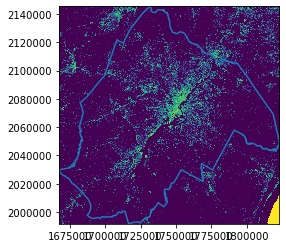

In [10]:
print("The MSA bounds are " + str(msa_bounds))


ll = msa_bounds[0], msa_bounds[1]
ur = msa_bounds[2], msa_bounds[3]

ij_ll = tuple(reversed(rasterio.transform.rowcol(transform, *ll)))
ij_ur = tuple(reversed(rasterio.transform.rowcol(transform, *ur)))

print("LL = {}, ij = {}".format(ll, ij_ll))
print("UR = {}, ij = {}".format(ur, ij_ur))

print("ij_LL = {}, LL = {}".format(ij_ll, rasterio.transform.xy(transform, *reversed(ij_ll))))
print("ij_UR = {}, UR = {}".format(ij_ur, rasterio.transform.xy(transform, *reversed(ij_ur))))

print("ij_LL = {}, LL = {}".format(ij_ll, transform * ij_ll))
print("ij_UR = {}, UR = {}".format(ij_ur, transform * ij_ur))


print("transform = {}".format(transform))


with rasterio.open(r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img','r') as fid:
    msa_boxed_imp_surf = fid.read(1, window = ((ij_ur[1], ij_ll[1]), (ij_ll[0], ij_ur[0])))
print('read image: {}'.format(msa_boxed_imp_surf.shape))

# used to plot the box and shape of an cbsa
plt.imshow(msa_boxed_imp_surf, extent=[msa_bounds[0], msa_bounds[2], msa_bounds[1], msa_bounds[3]])
msa_shply_xy = np.array(msa_shply.exterior.xy)
plt.plot(msa_shply_xy[0], msa_shply_xy[1])
plt.show()

In [11]:
# Takes in an MSA and returns a box of its impervious surface and its bounds
def box_msa(msa):
    msa_bounds = msa['shape'].bounds
    ll = msa_bounds[0], msa_bounds[1]
    ur = msa_bounds[2], msa_bounds[3]
    ij_ll = tuple(reversed(rasterio.transform.rowcol(transform, *ll)))
    ij_ur = tuple(reversed(rasterio.transform.rowcol(transform, *ur)))
    with rasterio.open(r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img','r') as fid:
        msa_boxed_imp_surf = fid.read(1, window = ((ij_ur[1], ij_ll[1]), (ij_ll[0], ij_ur[0])))
    return msa_boxed_imp_surf, msa_bounds

In [73]:
def masked_imp_surf_on_msa(msa):
    with rasterio.open(r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img','r') as fid:
        array, transform = rasterio.mask.mask(fid, msa, crop=True, nodata = -1)
    return array[0,:,:], transform


In [23]:
# Takes in an MSA and plots it.
def plotMSA(msa):
    if msa['geometry']['type'] == 'Polygon':
        x,y = msa['shape'].exterior.xy
        plt.plot(x,y)
    else:
        for poly in msa['shape']:
            x,y = poly.exterior.xy
            plt.plot(x,y)
    
    msa_boxed_imp_surf, msa_bounds = box_msa(msa)
    plt.imshow(msa_boxed_imp_surf, extent=[msa_bounds[0], msa_bounds[2], msa_bounds[1], msa_bounds[3]]) 
    plt.show()

In [69]:
# Runs through the list of MSAs and performs various functions on them
for msa in msas:
    # To access the polygons within a MultiPolygon run
    # for poly in msa['shape']:
    msa['shape'] = shapely.geometry.shape(msa['geometry'])

    #plotMSA(msa)
    #print(msa['properties']['NAME'])

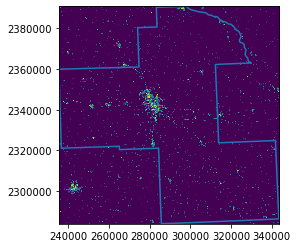

Rochester, MN
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
None


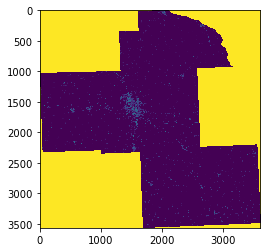

In [74]:
# Runs a test on one msa to see if we can mask impervious surface to the msa shape
plotMSA(msas[0])
print(msas[0]['properties']['NAME'])
# Converts the first msa to a shapely object
msa['shape'] = shapely.geometry.shape(msas[0]['geometry'])
# Gets a return of the masked data raster
maskedData, masked_transform = masked_imp_surf_on_msa(  [msas[0]['shape'],]  )


print(maskedData)
with rasterio.open(r'..\Data (Used)\NLCD_2016_Impervious_L48_20190405\NLCD_2016_Impervious_L48_20190405.img','r') as fid:
    print(fid.profile['nodata'])



msa_boxed_imp_surf, msa_bounds = box_msa(msas[0])
plt.imshow(maskedData) 
plt.show()

In [ ]:
np.where(np.isnan(array), 0, 1).sum()